In [2]:
import keras
import tensorflow as tf
import polars as pl
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

## Load and preprocess the training data
- Separate labels
- Normalize pixel values
- Train/validation split

In [4]:
train_full = tf.data.Dataset.from_tensor_slices(
    pl.read_csv('/kaggle/input/digit-recognizer/train.csv').to_numpy()
)
train_full = train_full.map(lambda x: (
    # Extract X and change value range to [0..1]
    tf.reshape(
        tf.multiply(tf.cast(x[1:], tf.float32), 1/255.0),
        [28, 28, 1]
    ),
    # Convert y to class probability.
    tf.one_hot(x[0], 10)
))

In [5]:
VALID_SIZE = int(len(train_full)*0.2)
train_dataset, valid_dataset = train_full.skip(VALID_SIZE), train_full.take(VALID_SIZE)

## Define and train the model
Two additions:

I'm placing RandomRotation layer to augment training data
Using Dropout layers after pooling and dense layers

In [6]:
model = keras.models.Sequential([
    keras.layers.Input([28, 28, 1]),
    keras.layers.RandomRotation(0.05,
                                fill_mode='constant',
                                fill_value=0.0),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=6, kernel_size=5, padding='same',
                        activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.AvgPool2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters=16, kernel_size=5, padding='valid',
                        activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.AvgPool2D(pool_size=2, strides=2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(84, activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=0.001
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.fit(
    train_dataset.batch(32),
    validation_data=valid_dataset.batch(32),
    batch_size=32,
    epochs=40,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.75, patience=2)
    ]
)

Epoch 1/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.7230 - loss: 0.8652 - val_accuracy: 0.9587 - val_loss: 0.1342 - learning_rate: 0.0010
Epoch 2/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9184 - loss: 0.2642 - val_accuracy: 0.9663 - val_loss: 0.1031 - learning_rate: 0.0010
Epoch 3/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9423 - loss: 0.1896 - val_accuracy: 0.9746 - val_loss: 0.0821 - learning_rate: 0.0010
Epoch 4/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9503 - loss: 0.1642 - val_accuracy: 0.9800 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 5/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9604 - loss: 0.1361 - val_accuracy: 0.9826 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 6/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9646 - loss: 0.1252 - val_accuracy: 0.9835 - val_loss: 0.0504 - learning_rate: 0.0010
Epoch 7/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accura

Model performance

In [7]:
model.evaluate(valid_dataset.batch(32))

263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9922 - loss: 0.0265


[0.029930029064416885, 0.9905952215194702]

Let's see the confusion matrix for the validation set.

263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


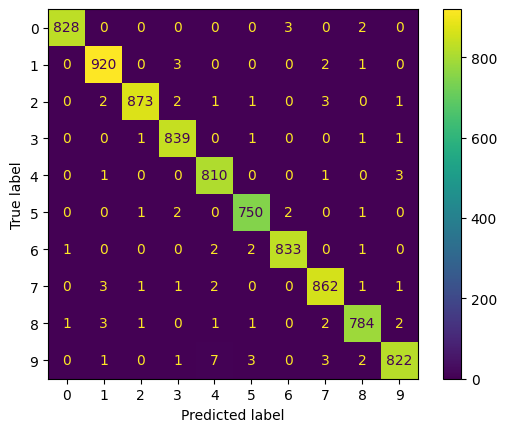

In [8]:
pred_probas = model.predict(valid_dataset.batch(32))
pred_y = tf.argmax(pred_probas, axis=1)
ConfusionMatrixDisplay.from_predictions(
    np.argmax(list(valid_dataset.map(lambda x, y: y).as_numpy_iterator()), axis=1),
    pred_y
);

Load the test data and produce the submission

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    pl.read_csv('/kaggle/input/digit-recognizer/test.csv').to_numpy()
).map(lambda x: (
    # Extract X and change value range to [0..1]
    tf.reshape(
        tf.multiply(tf.cast(x, tf.float32), 1/255.0),
        [28, 28, 1]
    ),
))

pred_probas = model.predict(test_dataset.batch(32))
pred_y = tf.argmax(pred_probas, axis=1)
submission = pl.DataFrame([
    pl.Series('ImageId', range(1, len(pred_y)+1)),
    pl.Series('Label', pred_y.numpy())
])
submission.write_csv('submission.csv')

875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
